# Imports

In [1]:
%config IPCompleter.use_jedi=False
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from platform import python_version
from functools import partial
import pathlib
import time

from functions import *
from visualizations import *

print("python_version: ", python_version())
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

# # specifically working for dgx not on local
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

%matplotlib inline

# %load_ext autoreload
# %reload_ext autoreload
# %autoreload 2

# %run visualizations

python_version:  3.8.10
TensorFlow version: 2.4.0
Keras version: 2.4.0


# Import model

In [2]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# Set Tensorflow config

In [3]:
set_tensorflow_config()

== TensorFlow Config options set ==


# Load Dataset
1. when only 1 train folder is present
2. when train, validation, and test split are present

## 1. When only 1 folder is present

In [4]:
abs_dataset_path = '/home/ubuntu/mount/Notebooks/abg/anuj_ws/image-datasets/cats_vs_dogs_redux/original/train/'

In [5]:
data_dir = pathlib.Path(abs_dataset_path)

In [6]:
list_ds_files = tf.data.Dataset.list_files(str(data_dir)+'/*/*', shuffle=False)

In [7]:
print("Total number of files loaded: {}".format(cardinality_check(list_ds_files)))

# OR

# total_files = len(list(data_dir.glob('*/*.jpg')))
# print("Total number of files: {}".format(total_files))

Total number of files loaded: 25000


In [8]:
train_ds_files, validation_ds_files, test_ds_files = split_dataset(list_ds_files)

In [9]:
NUM_TRAIN_FILES = cardinality_check(train_ds_files)
NUM_VALIDATION_FILES = cardinality_check(validation_ds_files)
NUM_TEST_FILES = cardinality_check(test_ds_files)

print("Number of training files: {}".format(NUM_TRAIN_FILES))
print("Number of validation files: {}".format(NUM_VALIDATION_FILES))
print("Number of test files: {}".format(NUM_TEST_FILES))

Number of training files: 15000
Number of validation files: 7500
Number of test files: 2500


In [10]:
CLASS_NAMES =  sorted(os.listdir(data_dir))
NUM_CLASSES = len(CLASS_NAMES)


print("Class names: {}".format(CLASS_NAMES))
print("Number of classes: {}".format(NUM_CLASSES))

Class names: ['cats', 'dogs']
Number of classes: 2


## 2. When train, validation, and test splits are present

In [11]:
# dataset_dir = '../image-datasets/PetImages_splits/'

In [12]:
# train_data_dir = os.path.join(dataset_dir, 'train')
# val_data_dir = os.path.join(dataset_dir, 'val')
# test_data_dir = os.path.join(dataset_dir, 'test')

In [13]:
# list_train_ds_files = tf.data.Dataset.list_files(str(train_data_dir + '/*/*'), shuffle=True)
# list_val_ds_files = tf.data.Dataset.list_files(str(val_data_dir + '/*/*'), shuffle=True)
# list_test_ds_files = tf.data.Dataset.list_files(str(test_data_dir + '/*/*'), shuffle=False)

In [14]:
# # Alternate method for cardinality check
# # NUM_TRAIN_FILES = len([file for file in glob(str(train_data_dir + '/*/*'))])
# # NUM_VALIDATION_FILES = len([file for file in glob(str(val_data_dir + '/*/*'))])
# # NUM_TEST_FILES = len([file for file in glob(str(test_data_dir + '/*/*'))])

# # OR 

# NUM_TRAIN_FILES = cardinality_check(list_train_ds_files)
# NUM_VALIDATION_FILES = cardinality_check(list_val_ds_files)
# NUM_TEST_FILES = cardinality_check(list_test_ds_files)

# print("Number of training files: {}".format(NUM_TRAIN_FILES))
# print("Number of validation files: {}".format(NUM_VALIDATION_FILES))
# print("Number of test files: {}".format(NUM_TEST_FILES))

In [15]:
# CLASS_NAMES = np.array(sorted([dir_name for dir_name in os.listdir(train_data_dir)]))
# NUM_CLASSES = len(CLASS_NAMES)

# print("Class names: {}".format(CLASS_NAMES))
# print("Number of classes: {}".format(NUM_CLASSES))

# Transfer Learning Parameters

In [16]:
# if you keep different batch size and epochs for transfer learning and fine tuning 
# then you need to reload dataset when doing fine tuning because the dataset is batched and repeated using these params
# if you want to be safe, reload the dataset separately when doing fine tuning
BATCH_SIZE = 64
EPOCHS = 100

TL_LEARNING_RATE = 0.001
TL_DROPOUT_RATE = 0.5

# this is not a hparam
TL_EXPERIMENT_NAME = '{}_CATS_DOGS_TL_PIPELINE'.format(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"))

# ETL Parameters

In [17]:
TRAIN_STEP_PER_EPOCHS = NUM_TRAIN_FILES/BATCH_SIZE
VALIDATION_STEPS_PER_EPOCHS = NUM_VALIDATION_FILES/BATCH_SIZE
TEST_STEPS_PER_EPOCHS = NUM_TEST_FILES/BATCH_SIZE

print("step size for training: ", TRAIN_STEP_PER_EPOCHS)
print("step size for validation: ", VALIDATION_STEPS_PER_EPOCHS)
print("step size for test: ", TEST_STEPS_PER_EPOCHS)

ONE_HOT = True

# sparse_categorical, binary
# CLASS_TYPE = 'sparse_categorical'
CLASS_TYPE = None

if NUM_CLASSES < 2:
    ONE_HOT = False
    CLASSIFIER = 'sigmoid'
    CLASS_TYPE = 'binary' 
else:
    CLASSIFIER = 'softmax'
    if not ONE_HOT:
        CLASS_TYPE = 'sparse_categorical'


IMG_SIZE = 299
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

step size for training:  234.375
step size for validation:  117.1875
step size for test:  39.0625


# Performance parameters

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
DATA_BUFFER_SIZE = 1000
INTERLEAVE_CYCLE_LENGTH = 4
SHUFFLE_BUFFER_SIZE = 5120

CALLBACK_PATIENCE = 5

# Train

In [19]:
train_ds = data_loader(ds_files=train_ds_files, 
                        is_train=True, 
                        is_aug=True,
                        is_preprocess=True,
                        is_test=False,
                        is_one_hot=ONE_HOT, 
                        batch_size=BATCH_SIZE, 
                        image_size=IMG_SIZE, 
                        num_classes=NUM_CLASSES, 
                        class_names=CLASS_NAMES, 
                        epochs=EPOCHS, 
                        interleave_cycle_length=INTERLEAVE_CYCLE_LENGTH, 
                        autotune=AUTOTUNE, 
                        shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                        preprocess_input=preprocess_input
                      )

Interleave applied
Augmentation applied
Model preprocess_input applied
Repeat and shuffle applied
Batch applied
Prefetch applied


In [20]:
train_ds

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 2)), types: (tf.float32, tf.float32)>

# Validation
* For validation dataset, you have to put `is_train=False` and `is_aug=False`

In [21]:
validation_ds = data_loader(ds_files=validation_ds_files, 
                            is_train=False, 
                            is_aug=False,
                            is_preprocess=True,
                            is_test=False,
                            is_one_hot=ONE_HOT, 
                            batch_size=BATCH_SIZE, 
                            image_size=IMG_SIZE, 
                            num_classes=NUM_CLASSES, 
                            class_names=CLASS_NAMES, 
                            epochs=EPOCHS, 
                            interleave_cycle_length=INTERLEAVE_CYCLE_LENGTH, 
                            autotune=AUTOTUNE, 
                            shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                            preprocess_input=preprocess_input
                      )

Interleave applied
Model preprocess_input applied
Batch applied
Prefetch applied


In [22]:
validation_ds

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 2)), types: (tf.float32, tf.float32)>

# Test

In [23]:
test_ds = data_loader(ds_files=test_ds_files, 
                        is_train=False, 
                        is_aug=False,
                        is_preprocess=True,
                        is_test=True,
                        is_one_hot=ONE_HOT, 
                        batch_size=BATCH_SIZE, 
                        image_size=IMG_SIZE, 
                        num_classes=NUM_CLASSES, 
                        class_names=CLASS_NAMES, 
                        epochs=EPOCHS, 
                        interleave_cycle_length=INTERLEAVE_CYCLE_LENGTH, 
                        autotune=AUTOTUNE, 
                        shuffle_buffer_size=SHUFFLE_BUFFER_SIZE, 
                        preprocess_input=preprocess_input
                      )

Model preprocess_input applied
Batch applied


In [24]:
test_ds

<BatchDataset shapes: ((None, 299, 299, 3), (None, 2)), types: (tf.float32, tf.float32)>

# Viz dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

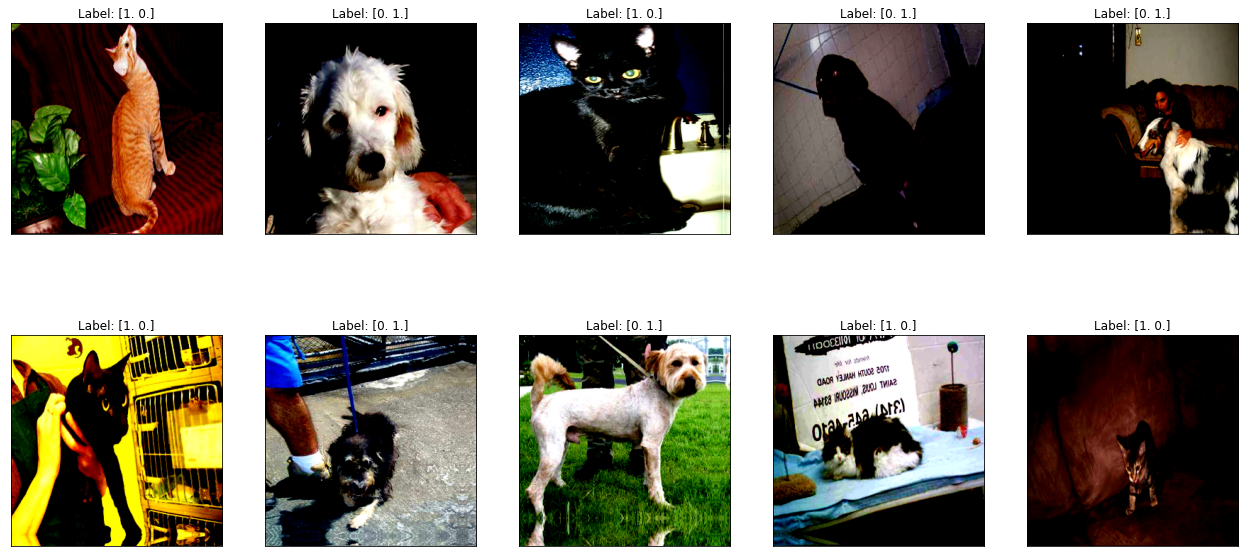

In [25]:
view_image(train_ds, view_albumentations=True)

# Build model

In [26]:
base_model = InceptionResNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
# from here till the classifier layer, it is all experimental 
# as to how many layers we think would be required that can help build a better model for our dataset

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(TL_DROPOUT_RATE)(x)  # Regularize with dropout

x = keras.layers.Dense(1024, activation='relu',name='fc-1')(x)
x = keras.layers.Dropout(TL_DROPOUT_RATE)(x)
x = keras.layers.Dense(512, activation='relu',name='fc-2')(x)
x = keras.layers.Dropout(TL_DROPOUT_RATE)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
fc-1 (Dense)                 (None, 1024)              1573888   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc-2 (Dense)                 (None, 512)               524800

# Metrics, Loss

In [27]:
metrics, loss, metric_to_monitor = get_loss_and_metrics(ONE_HOT, CLASS_TYPE)

# Callbacks

## Model checkpoint

In [28]:
model_checkpoint_callback = model_checkpoint(base_checkpoint_name='TL_MODEL', 
                                             checkpoint_dir_name=TL_EXPERIMENT_NAME,
                                             metrics_to_monitor=metric_to_monitor
                                            )

## Early Stopping

In [29]:
early_stopping_callback = early_stopping(patience_level=CALLBACK_PATIENCE)

## Tensorboard

In [30]:
dir_name = "logs/{}_transfer_learning".format(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"))
tensorboard_callback = tensorboard(log_dir_path=dir_name)

## Reduce LR

In [31]:
reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=CALLBACK_PATIENCE, mode='auto', verbose=1)

# Compile model

In [32]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics
             )

# Train model

In [33]:
start_time= time.perf_counter()

tl_history = model.fit(
            train_ds,
            steps_per_epoch = TRAIN_STEP_PER_EPOCHS,
            validation_data = validation_ds,
            validation_steps = VALIDATION_STEPS_PER_EPOCHS,
            callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback, reduceLR_callback],
            epochs=EPOCHS
)

end_time = time.perf_counter()

print("Total time taken (in sec): {}".format(end_time-start_time))

Epoch 1/100
234/234 [==============================] - 132s 432ms/step - loss: 0.1365 - categorical_accuracy: 0.9473 - val_loss: 0.0354 - val_categorical_accuracy: 0.9910

Epoch 00001: val_categorical_accuracy improved from -inf to 0.99100, saving model to 24_10_2021_09_59_51_CATS_DOGS_TL_PIPELINE/24_10_2021_10_00_15_TL_MODEL.epoch=01-val_acc=0.9910.h5
Epoch 2/100
234/234 [==============================] - 95s 406ms/step - loss: 0.0568 - categorical_accuracy: 0.9849 - val_loss: 0.0220 - val_categorical_accuracy: 0.9936

Epoch 00002: val_categorical_accuracy improved from 0.99100 to 0.99364, saving model to 24_10_2021_09_59_51_CATS_DOGS_TL_PIPELINE/24_10_2021_10_00_15_TL_MODEL.epoch=02-val_acc=0.9936.h5
Epoch 3/100
234/234 [==============================] - 94s 400ms/step - loss: 0.0381 - categorical_accuracy: 0.9884 - val_loss: 0.0183 - val_categorical_accuracy: 0.9952

Epoch 00003: val_categorical_accuracy improved from 0.99364 to 0.99523, saving model to 24_10_2021_09_59_51_CATS_DOGS

# Save history

In [34]:
pickle_filepath = './'
filename = 'tl_history'

save_pickle(tl_history.history, filename=filename, filepath=pickle_filepath)

Writing to pickle file: ./tl_history.pickle


# History Plots

In [35]:
print(tl_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [36]:
tl_history_df = pd.DataFrame(tl_history.history)

## Model Accuracy

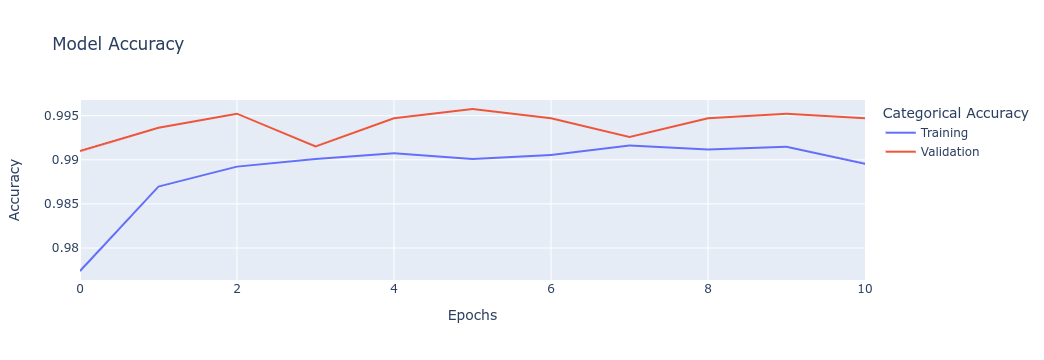

In [37]:
plot_history_accuracy(history_df=tl_history_df, renderer='jupyterlab')

## Model Loss

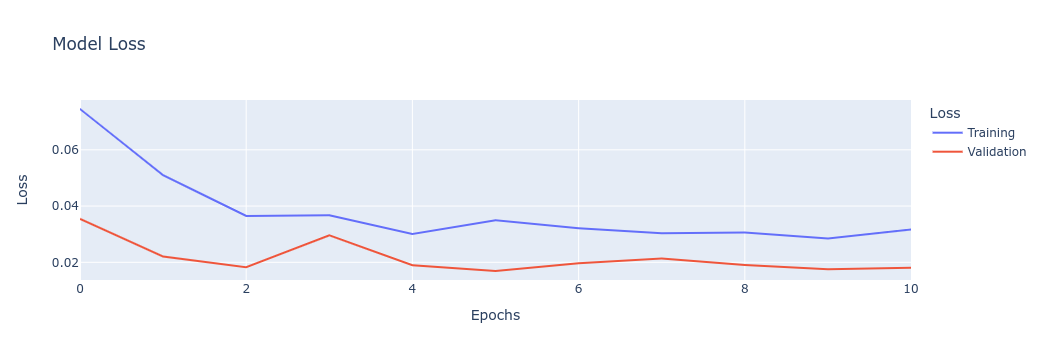

In [38]:
plot_history_loss(history_df=tl_history_df, renderer='jupyterlab')

# Model evaluation

In [39]:
model.evaluate(test_ds, steps=TEST_STEPS_PER_EPOCHS, return_dict=True)

39/39 [==============================] - 8s 203ms/step - loss: 0.0195 - categorical_accuracy: 0.9956


{'loss': 0.019545987248420715, 'categorical_accuracy': 0.9955999851226807}

# Fine Tuning

## Unfreeze model

In [40]:
base_model.trainable = True

## Check model layers

In [41]:
print_layers_state(model)

Layer Type  \
0  <tensorflow.python.keras.engine.input_layer.In...   
1  <tensorflow.python.keras.engine.functional.Fun...   
2  <tensorflow.python.keras.layers.pooling.Global...   
3  <tensorflow.python.keras.layers.core.Dropout o...   
4  <tensorflow.python.keras.layers.core.Dense obj...   
5  <tensorflow.python.keras.layers.core.Dropout o...   
6  <tensorflow.python.keras.layers.core.Dense obj...   
7  <tensorflow.python.keras.layers.core.Dropout o...   
8  <tensorflow.python.keras.layers.core.Dense obj...   

                 Layer Name  Layer Trainable  
0                   input_2             True  
1       inception_resnet_v2             True  
2  global_average_pooling2d             True  
3                   dropout             True  
4                      fc-1             True  
5                 dropout_1             True  
6                      fc-2             True  
7                 dropout_2             True  
8                     dense             True

# Fine Tuning Parameters

In [42]:
FT_LEARNING_RATE = 1e-5
# this is not a hparam
FT_EXPERIMENT_NAME = '{}_CATS_DOGS_FT_PIPELINE'.format(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"))

# Callbacks

## Model checkpoint

In [43]:
model_checkpoint_callback = model_checkpoint(base_checkpoint_name='FT_MODEL', 
                                             checkpoint_dir_name=FT_EXPERIMENT_NAME,
                                             metrics_to_monitor=metric_to_monitor
                                            )

## Early Stopping

In [44]:
early_stopping_callback = early_stopping(patience_level=CALLBACK_PATIENCE)

## Tensorboard

In [45]:
dir_name = "logs/{}_fine_tuning".format(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"))
tensorboard_callback = tensorboard(log_dir_path=dir_name)

## Reduce LR

In [46]:
reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=CALLBACK_PATIENCE, mode='auto', verbose=1)

# Re-compile Model

In [47]:
optimizer = tensorflow.keras.optimizers.Adam(FT_LEARNING_RATE)
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics
             )

# Fine Tune Model

In [48]:
start_time= time.perf_counter()

ft_history = model.fit(
            train_ds,
            steps_per_epoch=TRAIN_STEP_PER_EPOCHS,
            validation_data=validation_ds,
            validation_steps=VALIDATION_STEPS_PER_EPOCHS,
            callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback, reduceLR_callback],
            epochs=EPOCHS
)

end_time = time.perf_counter()

print("Total time taken (in sec): {}".format(end_time-start_time))

Epoch 1/100
234/234 [==============================] - 227s 808ms/step - loss: 0.0170 - categorical_accuracy: 0.9951 - val_loss: 0.0290 - val_categorical_accuracy: 0.9926

Epoch 00001: val_categorical_accuracy improved from -inf to 0.99258, saving model to 24_10_2021_10_17_34_CATS_DOGS_FT_PIPELINE/24_10_2021_10_17_34_FT_MODEL.epoch=01-val_acc=0.9926.h5
Epoch 2/100
234/234 [==============================] - 182s 775ms/step - loss: 0.0170 - categorical_accuracy: 0.9944 - val_loss: 0.0126 - val_categorical_accuracy: 0.9963

Epoch 00002: val_categorical_accuracy improved from 0.99258 to 0.99629, saving model to 24_10_2021_10_17_34_CATS_DOGS_FT_PIPELINE/24_10_2021_10_17_34_FT_MODEL.epoch=02-val_acc=0.9963.h5
Epoch 3/100
234/234 [==============================] - 182s 777ms/step - loss: 0.0151 - categorical_accuracy: 0.9954 - val_loss: 0.0098 - val_categorical_accuracy: 0.9974

Epoch 00003: val_categorical_accuracy improved from 0.99629 to 0.99735, saving model to 24_10_2021_10_17_34_CATS_DO

# Save history

In [49]:
pickle_filepath = './'
filename = 'ft_history'

save_pickle(ft_history.history, filename=filename, filepath=pickle_filepath)

Writing to pickle file: ./ft_history.pickle


# History Plots

In [50]:
print(ft_history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [51]:
ft_history_df = pd.DataFrame(ft_history.history)

## Model Accuracy

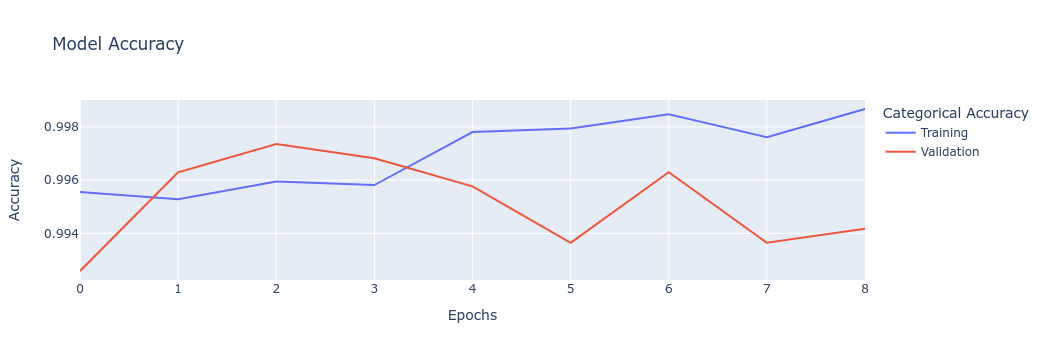

In [52]:
plot_history_accuracy(history_df=ft_history_df, renderer='jupyterlab')

## Model Loss

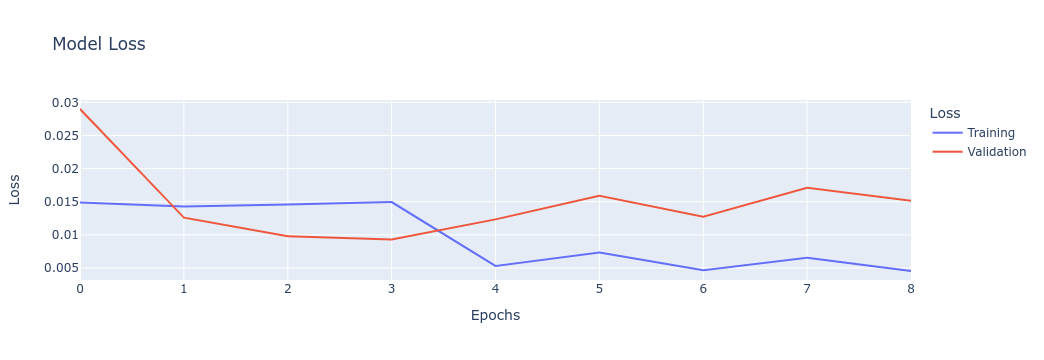

In [53]:
plot_history_loss(history_df=ft_history_df, renderer='jupyterlab')

# Evaluate model

In [54]:
model.evaluate(test_ds, steps=TEST_STEPS_PER_EPOCHS, return_dict=True)

39/39 [==============================] - 8s 192ms/step - loss: 0.0258 - categorical_accuracy: 0.9952


{'loss': 0.025791998952627182, 'categorical_accuracy': 0.995199978351593}

# Model prediction

In [55]:
predictions = model.predict(test_ds,  steps=TEST_STEPS_PER_EPOCHS, verbose=1)

39/39 [==============================] - 11s 190ms/step


In [56]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes.shape)

(2500,)


# Ground truth labels

In [57]:
ground_truth_label_list = test_ds_files.map(partial(get_label, ONE_HOT, CLASS_NAMES, NUM_CLASSES))

In [58]:
ground_truth_labels = np.stack(list(ground_truth_label_list.as_numpy_iterator()))

In [59]:
true_classes = np.argmax(ground_truth_labels, axis=1)
print(true_classes.shape)

(2500,)


# Save predictions and ground truth labels
* This is for model interpretation module

In [60]:
save_pickle(ground_truth_labels, "ground_truth_labels", "./")
save_pickle(predictions, "predictions", "./")

# optionally save 
#save_pickle(predicted_classes, "predicted_classes", "./")
#save_pickle(true_classes, "true_classes", "./")

Writing to pickle file: ./ground_truth_labels.pickle
Writing to pickle file: ./predictions.pickle
